In [0]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Activation
from keras.layers import Input, concatenate, Lambda 
#from keras.utils import np_utils
from keras.datasets import mnist
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input 
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import decode_predictions
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import os
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
import tensorflow as tf
from keras.applications import ResNet50
from multiprocessing.dummy import Pool
from tensorflow import keras
import seaborn as sns
from sklearn.manifold import TSNE
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.patheffects as PathEffects
from keras.utils import to_categorical
from keras import backend as K
#K.set_image_data_format('channels_first')
import numpy as np
import matplotlib.pyplot as plt

In [0]:
############## DATA ###########################

# load and shape data as usual, but here we don't process class labels
# to one-hot encoding. In fact, we don't exactly use class labels
# during training, only while setting up the triplets.
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [91]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000,)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000,)


In [0]:
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_test; X = X_test
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]

In [0]:
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(10)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(10)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

In [0]:
def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size) 
        yield [A, P, N], label

############## Loss ###########################

In [0]:
def identity_loss(y_true, y_pred):
    """This loss function just takes the mean of y_pred. Because of the
    way we wire the network (see complete_model below), y_pred is the
    output of the triplet loss, so minimising it is what we want to
    do."""
    return K.mean(y_pred)

In [0]:
def triplet_loss(x):
    """The triplet loss is ||A - P|| - ||A - N|| + alpha, where ||.||
    is the Euclidean norm. Notice that this is not a loss function in the
    format expected by Keras, ie f(y_true, y_pred)."""
    anchor, positive, negative = x
    
    # XXX YOUR CODE HERE: CALCULATE loss. USE K.
    # Compute the (encoding) distance between the anchor and the positive
    positive = K.sqrt(K.sum(K.square(anchor - positive), axis=-1, keepdims=True))
    # Step 2: Compute the (encoding) distance between the anchor and the negative, and to sum over axis=-1
    negative = K.sqrt(K.sum(K.square(anchor - negative), axis=-1, keepdims=True))
    # Step 3: subtract the two previous distances and add alpha.  
    basic_loss = (positive - negative)
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = K.mean(K.maximum(basic_loss + alpha,0))
    
    return loss

############## Model ###########################

In [0]:
def embedding_model():
    """A tiny model similar to the network we used for MNIST
    classification. We assume the architecture should be good for
    MNIST embedding. Its input is an image and output is an embedding,
    not a classification, so the final layer is not a softmax. We
    don't compile or add a loss since this will become a component in
    the complete model below."""
    model = Sequential()

    # XXX YOUR CODE HERE: ADD SOME LAYERS ENDING IN AN OUTPUT LAYER
    # APPROPRIATE FOR THE EMBEDDING.
    # First convolution layer has 32 filters with 3x3 kernel size and the input shape is the image size across 1 channel since the image is in gray scale
    model.add(Convolution2D(32, (3, 3), activation='relu',
                        input_shape=(imsize,imsize,1)))
    # Second convolution layer has again same 32 filters with 3x3 kernel size
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    # To reduce the image size by a factor of 2
    model.add(MaxPooling2D(pool_size=(2,2)))
    # To set certain portion of weights of our neurons to zero to make our system more robust 
    model.add(Dropout(0.25))
    # To bring our model from 2D to 1D before entering our Fully Connected Layer.
    model.add(Flatten())
    # After flatenning we can use our fully connected layer/Dense layers with 128 neurons
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # To create dense layer of 10 neurons
    model.add(Dense(10))
    # To see how our model look like
    #print(model.summary())
    
    return model

In [0]:
def complete_model(base_model):
    """This part of the model is quite tricky. Rather than a Sequential
    model, we declare a Model and say which are its inputs and
    outputs, and we declare how the outputs are calculated from the
    inputs. In particular, there are no layers in this model, *other
    than* the layers in the embedding model discussed above.

    A further complication is that our triplet loss can't be
    calculated as a function of y_true and y_predicted as
    usual. Instead we calculate the triplet loss as an extra Lambda
    layer. Then the Model's loss is set to be equal to the triplet
    loss via the identity function."""

    
    input_1 = Input((imsize, imsize, 1))
    input_2 = Input((imsize, imsize, 1))
    input_3 = Input((imsize, imsize, 1))

    # call the base_model three times to get A, P, N
    ## The em_model model instance is shared (Siamese network)
    # XXX YOUR CODE HERE.
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triplet_loss)([A, P, N]) 
    model1 = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model1.compile(loss=identity_loss, optimizer=Adam(LR))
    return model1

In [0]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
############## Settings ###########################

imsize = 28

# XXX you might like to play with some of these hyperparameters
batch_size = 100
# 2D is interesting for visualisation, but higher allows more "space"
# to achieve accuracy in complex domains, eg 128 is common for
# faces. but MNIST is simple, so maybe 2 is enough for us anyway.
embedding_dim = 2 
LR = 0.0001 # be careful: too large will be unstable for our data
EPOCHS = 15
alpha = 0.2 # interesting to think about different values

############## Main ###############################

In [96]:
# create the data generators
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

# instantiate the model and take a look
em_model = embedding_model()
model = complete_model(em_model)

# XXX YOUR CODE HERE: create the embedding model and then use
# that to create the complete model
print(model.summary())

# fit

# XXX YOUR CODE HERE: call fit_generator() to fit the model.
H = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    workers=1,
                    steps_per_epoch=20, 
                    validation_steps=30,
                    use_multiprocessing=False)
#To save the weights of the model
model.save_weights("keras_mnist.h5")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 10)           600810      input_8[0][0]                    
                                                                 input_9[0][0]                    
          

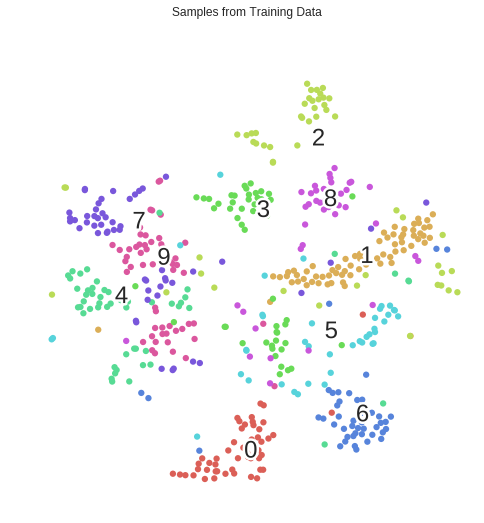

In [72]:
# To visualize samples from training data before embedding
x_train_flat = X_train.reshape(-1,784)
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

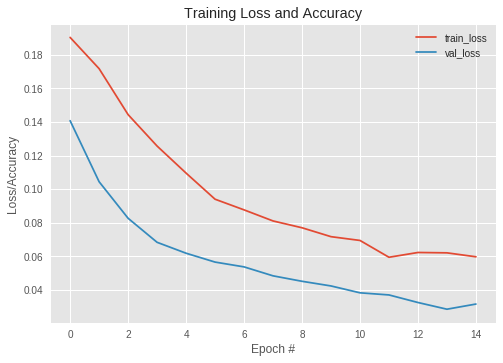

In [14]:
# plot the training loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("keras_mnist.png")

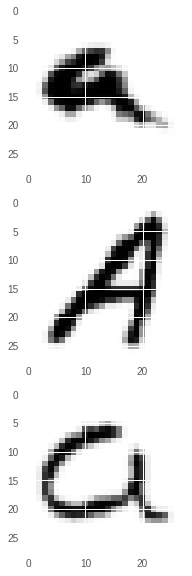

In [97]:
letter_img = np.load("emnist_train_images_3.npy")

# plot the first image in the letter dataset. "squeeze" removes the useless
# final dimension (we only have greyscale, not RGB).
fig = plt.figure(figsize=(10, 10))
for i in range(3):
  sub = fig.add_subplot(3, 1, i+1)
  plt.imshow(letter_img[i, :, :, :].squeeze(), cmap=plt.get_cmap("Greys"))

In [0]:
# To see weights of my embedding layer
em_model.get_weights()

In [0]:
# To get embeddings for my training dataset
train_embeddings = em_model.predict(X_train)

In [74]:
# To check how my embeddings are performing on a KNN model using Scikit
kNNmodel = KNeighborsClassifier(n_neighbors=1)
# Train the model using the training sets
kNNmodel.fit(train_embeddings,y_train)
#Get the embeddings for our test data
test_embeddings = em_model.predict(X_test)
#Predict the response for test dataset
y_pred = kNNmodel.predict(test_embeddings)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8927


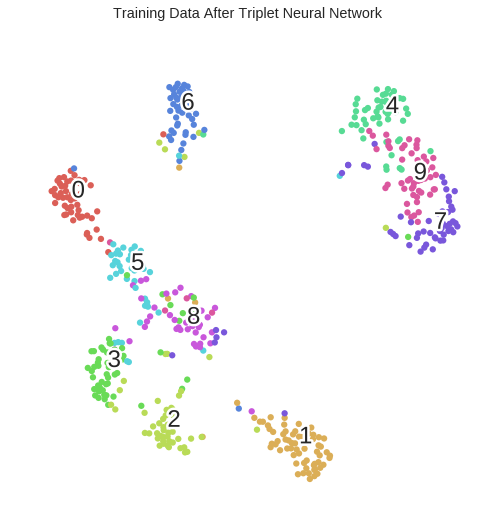

In [16]:
tsne = TSNE()
X_train_trm = em_model.predict(X_train[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
scatter(train_tsne_embeds, y_train[:512], "Training Data After Triplet Neural Network")

In [0]:
# To convert target variable to One Hot Encoding
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [100]:
y_train = encode(y_train)
print(y_train)

Shape of data (BEFORE encode): (60000,)
Shape of data (AFTER  encode): (60000, 10)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [0]:
# To create a simple model with 1 hidden layer with 5 neurons and 10 neurons in Input since my embedding layer gives an output of size 10
recomodel = Sequential()
recomodel.add(Dense(5,input_shape=(10,)))
# To get a probability for the prediction of each number 0 - 9 from the softmax
recomodel.add(Dense(10, activation='softmax'))
# Optimizer ADAM self adapts the learning rate
recomodel.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [108]:
# To train the neural network based on my trained images embeddings and class labels
recomodel.fit(train_embeddings, y_train, epochs=EPOCHS)

Epoch 1/15
60000/60000 [==============================] - 8s 134us/step - loss: 2.1921 - acc: 0.2475
Epoch 2/15
60000/60000 [==============================] - 7s 124us/step - loss: 1.9452 - acc: 0.3368
Epoch 3/15
60000/60000 [==============================] - 7s 124us/step - loss: 1.6920 - acc: 0.4678
Epoch 4/15
60000/60000 [==============================] - 7s 125us/step - loss: 1.4604 - acc: 0.5502
Epoch 5/15
60000/60000 [==============================] - 8s 126us/step - loss: 1.2524 - acc: 0.5999
Epoch 6/15
60000/60000 [==============================] - 8s 126us/step - loss: 1.0763 - acc: 0.6500
Epoch 7/15
60000/60000 [==============================] - 8s 125us/step - loss: 0.9413 - acc: 0.6998
Epoch 8/15
60000/60000 [==============================] - 7s 125us/step - loss: 0.8440 - acc: 0.7326
Epoch 9/15
60000/60000 [==============================] - 7s 125us/step - loss: 0.7745 - acc: 0.7591
Epoch 10/15
60000/60000 [==============================] - 8s 127us/step - loss: 0.7255 - a

In [0]:
def recognition(img):
  bestconf = -1
  flag = 0
  prediction = recomodel.predict(em_model.predict(img))[0]
  #print(predictiondigit)
  plt.imshow(img[0, :, :, :].squeeze(), cmap=plt.get_cmap("Greys"))
  for n in [0,1,2,3,4,5,6,7,8,9]:
    if(prediction[n] > bestconf and prediction[n] < 0.95):
      bestClass = str(n)
      bestconf = prediction[n]
    elif(prediction[n] > 0.95):
      flag = 1
      break

  if flag ==0:
    print("This digit is " + bestClass + " with " + str(bestconf * 100) + "% confidence")
  else:
    print("This image is a letter")

This image is a letter
This digit is 9 with 77.1282970905304% confidence


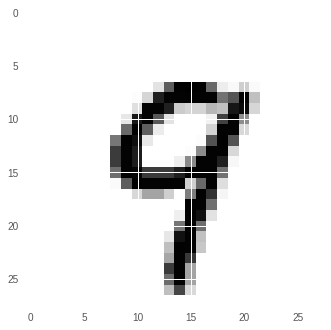

In [116]:
# To check my recognition function for a given digit and a letter
recognition(letter_img[2:3])
# Recognize a digit in my test dataset
recognition(X_test[12:13])

This image is a letter
This image is a letter
This image is a letter


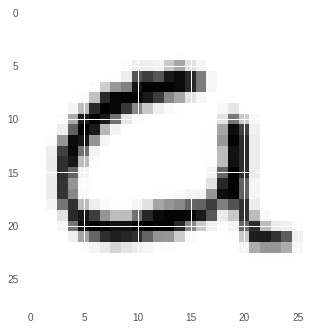

In [121]:
#Testing my network with (unseen) images of letters , to demonstrate that my model works.
for i in range(len(letter_img)):
  recognition(letter_img[i:i+1])

################PART 2##################

In this part I have compared the performance between  built in VGG16 face model in Keras and also created a model to load VGG Face Weights which are tuned for face recognition.

In [123]:
# To use the VGG16 model built in KERAS
# Convolution Features
vggmodel = VGG16(weights = 'imagenet',include_top=False) # pooling: None
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [127]:
vgg16_feature_list = []
names = []
items = os.listdir('/content')
for each_image in items:
  # To fetch all images ending with .jpg
  if each_image.endswith(".jpg"):
     #print (each_image)
    names.append(each_image)
    img = image.load_img(each_image, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    #To find the embeddings from this model for my custom images
    features = vggmodel.predict(x)
    features_np = np.array(features)
    vgg16_feature_list.append(features_np.flatten())
#to collapse a feature from the model (where different pre-trained models produce different shapes of features) 
#into an one-dimension array required by kMeans in Scikit-Learn
vgg16_feature_list_np = np.array(vgg16_feature_list)
print(vgg16_feature_list_np.shape)

(34, 25088)


In [128]:
# To find the appropriate number of clusters that I would be requiring for KMeans
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vgg16_feature_list_np)
  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed clusters
  silhouette_avg = silhouette_score(vgg16_feature_list_np, kmeans.labels_)
  print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.043859605
For n_clusters = 4 The average silhouette_score is : 0.04444409
For n_clusters = 5 The average silhouette_score is : 0.034652628
For n_clusters = 6 The average silhouette_score is : 0.036747877


In [130]:
# In order to visualize KMeans on 2D I am doing PCA which lets us visualize the first 2 principal components and give an intuition about
# how the clusters look along the first two principal components
# PCA is effected by scale so you need to scale the features in your data before applying PCA
vgg16_feature_list_np = StandardScaler().fit_transform(vgg16_feature_list_np)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(vgg16_feature_list_np)
kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(principalComponents)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf["Names"] = names
principalDf["Clusters"] = kmeans
# To see our data frame
principalDf


,principal component 1,principal component 2,Names,Clusters
0,-4.265784,-9.794271,Tiger_Woods_0004.jpg,0
1,-3.447831,-10.739245,Rick_Perry_0003.jpg,0
2,-10.989921,-19.981909,Rick_Perry_0001.jpg,0
3,8.324099,-7.872009,Tom_Cruise_0010.jpg,0
4,-5.421933,-6.478448,Tiger_Woods_0007.jpg,0
5,5.913688,-9.781157,Tom_Cruise_0005.jpg,0
6,-8.582747,-18.023445,Tiger_Woods_0006.jpg,0
7,-6.529727,-10.031384,Rick_Perry_0004.jpg,0
8,-2.342543,-7.624781,Tom_Cruise_0002.jpg,0
9,-7.665443,-8.334851,Tiger_Woods_0018.jpg,0


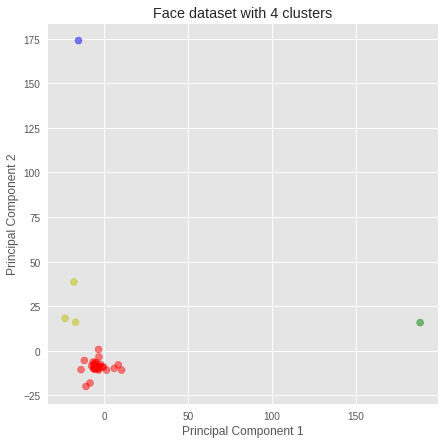

In [131]:
# Now lets visualize my Clusters after KMeans clustering.
# We can see that we do not have very well defined clusters using VGG16 built in Keras Model.
# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b', 3 : 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) 
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Face dataset with 4 clusters')
plt.show()

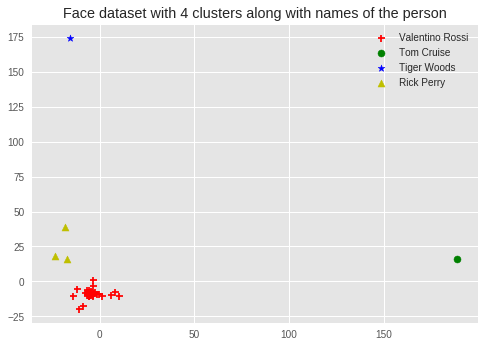

In [132]:
# To give a better intuition about our clusters with our below plot
for i in range(0, principalComponents.shape[0]):
  if principalDf.Clusters[i] == 0:
    c1 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='r',
    marker='+')
  elif principalDf.Clusters[i] == 1:
    c2 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='g',
    marker='o')
  elif principalDf.Clusters[i] == 2:
    c3 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='b',
    marker='*')
  elif principalDf.Clusters[i] == 3:
    c4 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='y',
    marker='^')
plt.legend([c1, c2, c3, c4], ['Valentino Rossi', 'Tom Cruise', 'Tiger Woods', 'Rick Perry'])
plt.title('Face dataset with 4 clusters along with names of the person')
plt.show()

In [0]:
#Lets construct the Face Model to load VGG Face Weights
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
 
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(256, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Convolution2D(512, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(2,2)))
  
  model.add(Convolution2D(4096, (7, 7), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(4096, (1, 1), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Convolution2D(2622, (1, 1)))
  model.add(Flatten())
  model.add(Activation('softmax'))

In [134]:
# To mount my drive in order to access the weights in my google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.models import model_from_json
model.load_weights('drive/My Drive/Assignment2_Keras_Images/vgg_face_weights.h5')

In [137]:
# To remove final layers of our model to get a useful embedding of my image
vgg_face_descriptor = Model(inputs=model.layers[0].input
, outputs=model.layers[-2].output)

vgg_face_descriptor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_27_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_29 (ZeroPaddi (None, 114, 114, 64)      0         
__________

In [141]:
vgg_face_feature = []
names = []
items = os.listdir('/content')
for each_image in items:
  if each_image.endswith(".jpg"):
    names.append(each_image)
    img = image.load_img(each_image, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = vgg_face_descriptor.predict(x)
    features_np = np.array(features)
    vgg_face_feature.append(features_np.flatten())
#to collapse a feature from the model (where different pre-trained models produce different shapes of features) 
#into an one-dimension array required by kMeans in Scikit-Learn
vgg_face_feature_np = np.array(vgg_face_feature)
print(vgg_face_feature_np.shape)

(34, 2622)


In [142]:
# To find the appropriate number of clusters that I would be requiring for KMeans
range_n_clusters = [3, 4, 5, 6]
for n_clusters in range_n_clusters:
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vgg_face_feature_np)
  # The silhouette_score gives the average value for all the samples.
  # This gives a perspective into the density and separation of the formed clusters
  silhouette_avg = silhouette_score(vgg_face_feature_np, kmeans.labels_)
  print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.23125371
For n_clusters = 4 The average silhouette_score is : 0.22779317
For n_clusters = 5 The average silhouette_score is : 0.20330112
For n_clusters = 6 The average silhouette_score is : 0.13424623


In [143]:
# In order to visualize KMeans on 2D I am doing PCA which lets us visualize the first 2 principal components and give an intuition about
# how the clusters look along the first two principal components
#PCA is effected by scale so you need to scale the features in your data before applying PCA
vgg_face_feature_np = StandardScaler().fit_transform(vgg_face_feature_np)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(vgg_face_feature_np)
kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(principalComponents)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', "principal component 3"])
principalDf["Names"] = names
principalDf["Clusters"] = kmeans
principalDf

,principal component 1,principal component 2,principal component 3,Names,Clusters
0,-17.952324,-5.956541,-0.860646,Tiger_Woods_0004.jpg,2
1,-4.955208,-33.852146,-27.764402,Rick_Perry_0003.jpg,0
2,-9.561666,-29.861605,-6.041251,Rick_Perry_0001.jpg,0
3,40.102657,3.073772,0.353263,Tom_Cruise_0010.jpg,1
4,-19.247698,7.372134,0.152562,Tiger_Woods_0007.jpg,3
5,36.280121,5.125849,-1.965802,Tom_Cruise_0005.jpg,1
6,-22.121088,10.236031,0.541613,Tiger_Woods_0006.jpg,3
7,-12.346904,-26.627579,-28.402405,Rick_Perry_0004.jpg,0
8,34.203812,2.974900,-0.038846,Tom_Cruise_0002.jpg,1
9,-19.823133,37.333458,-5.039153,Tiger_Woods_0018.jpg,3


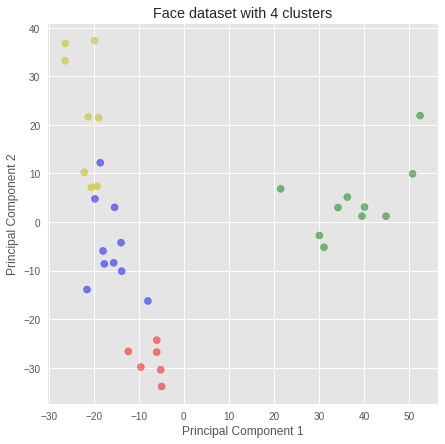

In [144]:
# Now lets visualize my Clusters after KMeans clustering.
# We can see that we have well defined clusters in this case using VGG face weights fine tuned for facial recognition.
# Define our own color map
LABEL_COLOR_MAP = {0 : 'r',1 : 'g',2 : 'b', 3 : 'y'}
label_color = [LABEL_COLOR_MAP[l] for l in kmeans]

# Plot the scatter digram
plt.figure(figsize = (7,7))
plt.scatter(principalComponents[:,0],principalComponents[:,1], c= label_color, alpha=0.5) 
#plt.legend(loc='Clusters', fancybox=True, fontsize=8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Face dataset with 4 clusters')
plt.show()

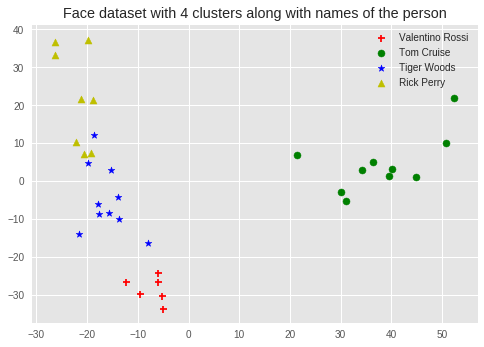

In [145]:
# To give a better intuition about our clusters with our below plot
for i in range(0, principalComponents.shape[0]):
  if principalDf.Clusters[i] == 0:
    c1 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='r',
    marker='+')
  elif principalDf.Clusters[i] == 1:
    c2 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='g',
    marker='o')
  elif principalDf.Clusters[i] == 2:
    c3 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='b',
    marker='*')
  elif principalDf.Clusters[i] == 3:
    c4 = plt.scatter(principalComponents[i,0],principalComponents[i,1],c='y',
    marker='^')
plt.legend([c1, c2, c3, c4], ['Valentino Rossi', 'Tom Cruise', 'Tiger Woods', 'Rick Perry'])
plt.title('Face dataset with 4 clusters along with names of the person')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


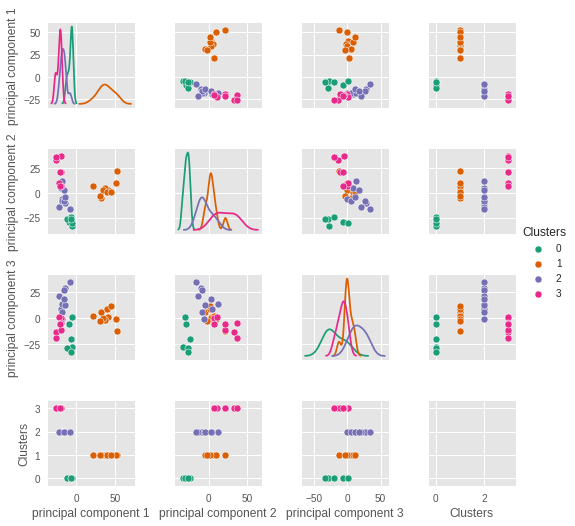

In [146]:
#the above plot above was only for 2 PCA projections however to generate a KMeans visualisation for other possible combinations 
#of projections I have used Seaborn's pairplot function to do the job
# Call Seaborn's pairplot to visualize our KMeans clustering on the PCA projected data
sns.pairplot(principalDf, hue='Clusters', palette= 'Dark2', diag_kind='kde',size=1.85)

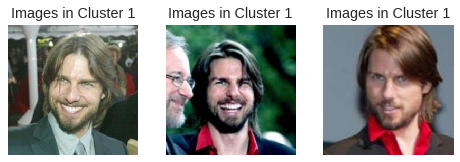

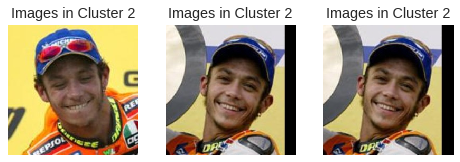

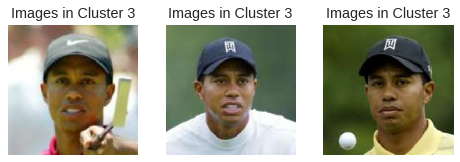

In [148]:
for i in range(len(set(kmeans))):
  #fig = plt.figure(figsize=(2, 2))
  if i == 0:
    plt.subplot(1, 3, i+1)
    plt.title('Images in Cluster 1')
    plt.xticks([])
    plt.yticks([])
    image1 = cv2.imread("Tom_Cruise_0002.jpg")
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    image2 = cv2.imread("Tom_Cruise_0003.jpg")
    plt.subplot(1, 3, i+2)
    plt.title('Images in Cluster 1')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    image3 = cv2.imread("Tom_Cruise_0004.jpg")
    plt.subplot(1, 3, i+3)
    plt.title('Images in Cluster 1')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
    plt.show()
  elif i == 1:
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 2')
    image1 = cv2.imread("Valentino_Rossi_0001.jpg")
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 2')
    image2 = cv2.imread("Valentino_Rossi_0002.jpg")
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 2')
    image3 = cv2.imread("Valentino_Rossi_0002.jpg")
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.show()
  elif i == 2:
    plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 3')
    image1 = cv2.imread("Tiger_Woods_0017.jpg")
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 3')
    image2 = cv2.imread("Tiger_Woods_0015.jpg")
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    plt.title('Images in Cluster 3')
    image3 = cv2.imread("Tiger_Woods_0016.jpg")
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
    

#fig = plt.figure(figsize=(10, 10))
#for i in range(3):
 # sub = fig.add_subplot(3, 1, i+1)